In [ ]:
!pip install numpy pandas yfinance matplotlib scikit-learn tensorflow

[*********************100%***********************]  1 of 1 completed

Epoch 1/50



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4821e-04 - val_loss: 0.0011
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3601e-04 - val_loss: 8.4460e-04
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0603e-04 - val_loss: 9.0588e-04
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.1648e-04 - val_loss: 8.4674e-04
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.5321e-05 - val_loss: 7.9596e-04
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.5015e-05 - val_loss: 9.6705e-04
Epoch 8/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.9981e-05 - val_loss: 6.7959e-04
Epoch 9/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 7.5163e-05 - val_loss: 6.5692e-04
Epoch 10/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.6968e-05 - val_loss: 8.7725e-04
Epoch 11/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.0870e-05 - val_loss: 0.0011
Epoch

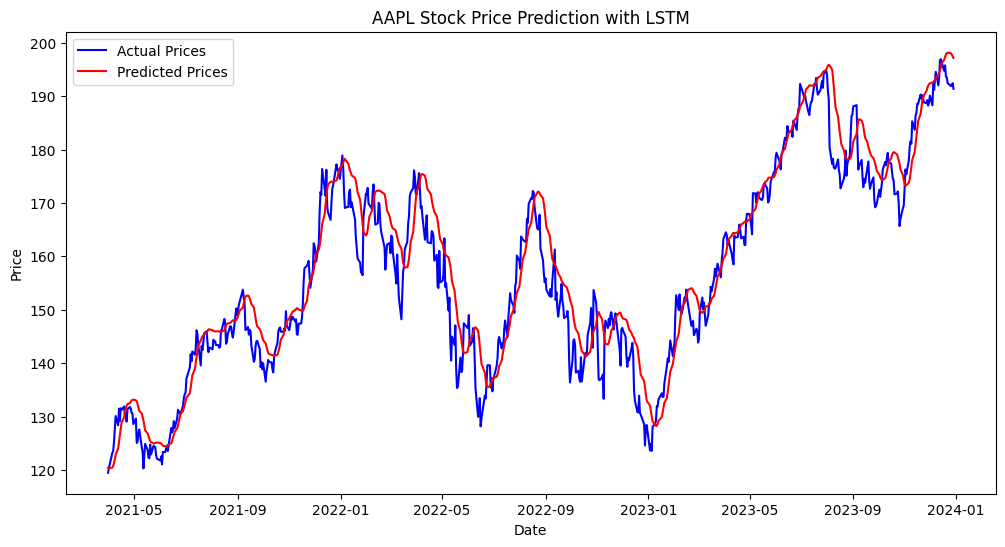

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load data
stock = yf.download('AAPL', start='2010-01-01', end='2024-01-01')
data = stock['Close'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60  # 60 days
X, y = create_sequences(data_scaled, seq_length)

# Split into training and testing
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# Build LSTM model with Dropout
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),  # Dropout to prevent overfitting
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Add EarlyStopping to prevent unnecessary training
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Train the model with validation split
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stop])

# Predictions for training and testing
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform predictions and actual values
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1,1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))

# Train Performance Metrics
train_mae = mean_absolute_error(y_train_actual, train_predictions)
train_mse = mean_squared_error(y_train_actual, train_predictions)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train_actual, train_predictions)
train_mean_actual_price = np.mean(y_train_actual)
train_accuracy = 100 - (train_mae / train_mean_actual_price * 100)

# Test Performance Metrics
test_mae = mean_absolute_error(y_test_actual, test_predictions)
test_mse = mean_squared_error(y_test_actual, test_predictions)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test_actual, test_predictions)
test_mean_actual_price = np.mean(y_test_actual)
test_accuracy = 100 - (test_mae / test_mean_actual_price * 100)

# Print Performance Metrics
print(f"📊 Model Performance Metrics:")
print(f"🔹 Training Accuracy: {train_accuracy:.2f}%")
print(f"🔹 Testing Accuracy: {test_accuracy:.2f}%")
print(f"Train MAE: {train_mae:.2f} | Train RMSE: {train_rmse:.2f} | Train R² Score: {train_r2:.4f}")
print(f"Test MAE: {test_mae:.2f} | Test RMSE: {test_rmse:.2f} | Test R² Score: {test_r2:.4f}")

# Plot results
plt.figure(figsize=(12,6))
plt.plot(stock.index[-len(y_test):], y_test_actual, label='Actual Prices', color='blue')
plt.plot(stock.index[-len(y_test):], test_predictions, label='Predicted Prices', color='red')
plt.legend()
plt.title("AAPL Stock Price Prediction with LSTM")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


